# Setting up a parcels run

In [89]:
import math
from datetime import timedelta
from glob import glob
from netCDF4 import Dataset
import os
import sys
# import proj

import matplotlib.pyplot as plt
import numpy as np
import trajan as ta
import xarray as xr

from parcels import (
    AdvectionRK4,
    FieldSet,
    JITParticle,
    ParticleSet,
)

In [247]:
input_datasets = {
        # 'input_base_dir': os.path.abspath('/hpcfreenas/hindcast'),
        'input_base_dir': os.path.abspath('/scratch/local1'),
    }

input_datasets['rom'] = {
    'path_to_hindcast': os.path.join(
        input_datasets['input_base_dir'],
        'ROMS/doppio_bay_02' if sys.platform == 'linux' else 'rom'
        ),
    'file_mask': 'doppio_his_201*.nc',
    # 'transformer': proj.Transformer.from_crs(
    #     proj.CRS.from_epsg(4326), # WGS84
    #     proj.CRS.from_epsg(32619), # UTM19N
    #     always_xy=True),
    'data_dt': 3600, # seconds
    'release_points_lon_lat': np.array([
        [-74.8860462 ,  35.44369297],
        [-74.52862058,  34.2950443 ],
        [-74.21067673,  34.67342632],
        [-73.95323861,  35.41533207],
        [-73.46990185,  35.73379049],
        [-73.18779878,  39.79203454],
        [-72.84653146,  38.95630874],
        [-72.63457538,  36.91732252],
        [-72.59191209,  40.63632652],
        [-72.19871125,  35.34782645],
        [-71.16154411,  36.63844384],
        [-70.09004307,  38.54977471],
        [-69.9444851 ,  38.71378714],
        [-69.84821837,  42.92174757],
        [-69.80693744,  40.67720343],
        [-68.10444023,  41.69506538],
        [-67.62495283,  41.95124591],
        [-64.79557692,  42.78925352],
        [-64.51109065,  43.15402752],
        [-64.26535265,  39.81402787],
        [-63.43641926,  41.95324376],
        [-63.04835776,  43.70211662],
        [-62.37610229,  41.41986588],
        [-61.84710945,  43.14830997],
        [-61.12644699,  42.29980774],
        ])

}

In [248]:
files = glob(os.path.join(input_datasets['rom']['path_to_hindcast'],input_datasets['rom']['file_mask']))
files = sorted(files)
files = files[:1]

In [249]:
files

['/scratch/local1/ROMS/doppio_bay_02/doppio_his_20180101_0000_0001.nc']

In [250]:
# fix time stamps as parcels doesn't handle them 
timestamps = []
for ii,item in enumerate(files):
    df = Dataset(item)
    time = df.variables['ocean_time']

    base_date = np.datetime64('2006-01-01T00:00:00')
    timedeltas = time[:].astype('timedelta64[s]')
    timestamps_file = base_date + timedeltas

    # timestamps = np.concatenate((timestamps, timestamps_file))
    timestamps.append(timestamps_file)

    df.close()

timestamps = np.array(timestamps)


    
    # if ii > 2: break

In [251]:

# Save to a text file
np.savetxt('timestamps_of_doppio_first_10d.txt', timestamps.astype(str), fmt='%s')
np.loadtxt('timestamps_of_doppio_first_10d.txt', dtype='datetime64[s]')

array(['2018-01-01T00:00:00', '2018-01-01T01:00:00',
       '2018-01-01T02:00:00', '2018-01-01T03:00:00',
       '2018-01-01T04:00:00', '2018-01-01T05:00:00',
       '2018-01-01T06:00:00', '2018-01-01T07:00:00',
       '2018-01-01T08:00:00', '2018-01-01T09:00:00',
       '2018-01-01T10:00:00', '2018-01-01T11:00:00',
       '2018-01-01T12:00:00', '2018-01-01T13:00:00',
       '2018-01-01T14:00:00', '2018-01-01T15:00:00',
       '2018-01-01T16:00:00', '2018-01-01T17:00:00',
       '2018-01-01T18:00:00', '2018-01-01T19:00:00',
       '2018-01-01T20:00:00', '2018-01-01T21:00:00',
       '2018-01-01T22:00:00', '2018-01-01T23:00:00',
       '2018-01-02T00:00:00'], dtype='datetime64[s]')

In [ ]:
FieldSet.from_netcdf

In [252]:
fieldset = FieldSet.from_netcdf(
    filenames = files,
    variables = {
        'U': 'u',
        'V': 'v'},
    # the dimensions here are wrong. it should be xi_u, eta_U - good enough for now
    dimensions = {
        'U': {'lon': 'lon_u', 'lat': 'lat_u', 'depth': 's_rho'},
        'V': {'lon': 'lon_v', 'lat': 'lat_v', 'depth': 's_rho'},
    },
    timestamps = timestamps,
    deferred_load = False,
)

  0%|          | 300.0/864000.0 [00:12<23:56, 601.17it/s]

In [253]:
pulse = 1000
spawn_points = input_datasets['rom']['release_points_lon_lat'][np.random.choice(np.arange(len(input_datasets['rom']['release_points_lon_lat'])),size=pulse)]
pset = ParticleSet.from_list(
    fieldset=fieldset,  # the fields on which the particles are advected
    pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
    lon=spawn_points[:,0],  # a vector of release longitudes
    lat=spawn_points[:,1],  # a vector of release latitudes
)

/home/zmaw/u301513/.conda/envs/parcels/lib/python3.12/site-packages/matplotlib/colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


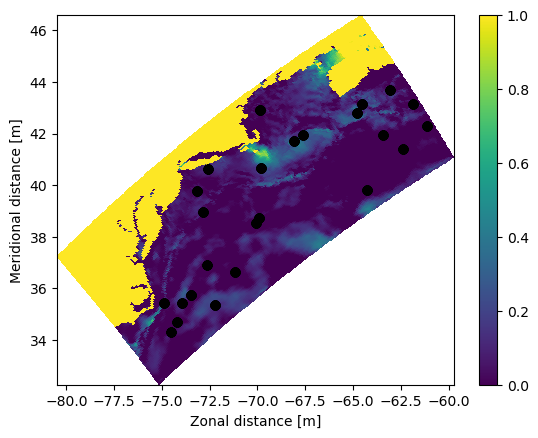

In [254]:
# fieldset.computeTimeChunk()

plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0,1,:-1,:-1],vmin = 0,vmax = 1)
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

plt.plot(pset.lon, pset.lat, "ko")
plt.show()

In [255]:
output_file = pset.ParticleFile(
    name="test.zarr",  # the file name
    outputdt=timedelta(days=10),  # the time step of the outputs
)
pset.execute(
    AdvectionRK4,  # the kernel (which defines how particles move)
    runtime=timedelta(days=10),  # the total length of the run
    dt=timedelta(minutes=5),  # the timestep of the kernel
    output_file=output_file,
)

INFO: Output files are stored in test.zarr.
100%|██████████| 864000.0/864000.0 [00:02<00:00, 390620.97it/s]


/home/zmaw/u301513/.conda/envs/parcels/lib/python3.12/site-packages/trajan/plot/__init__.py:159: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num = self.ds.dims['trajectory']


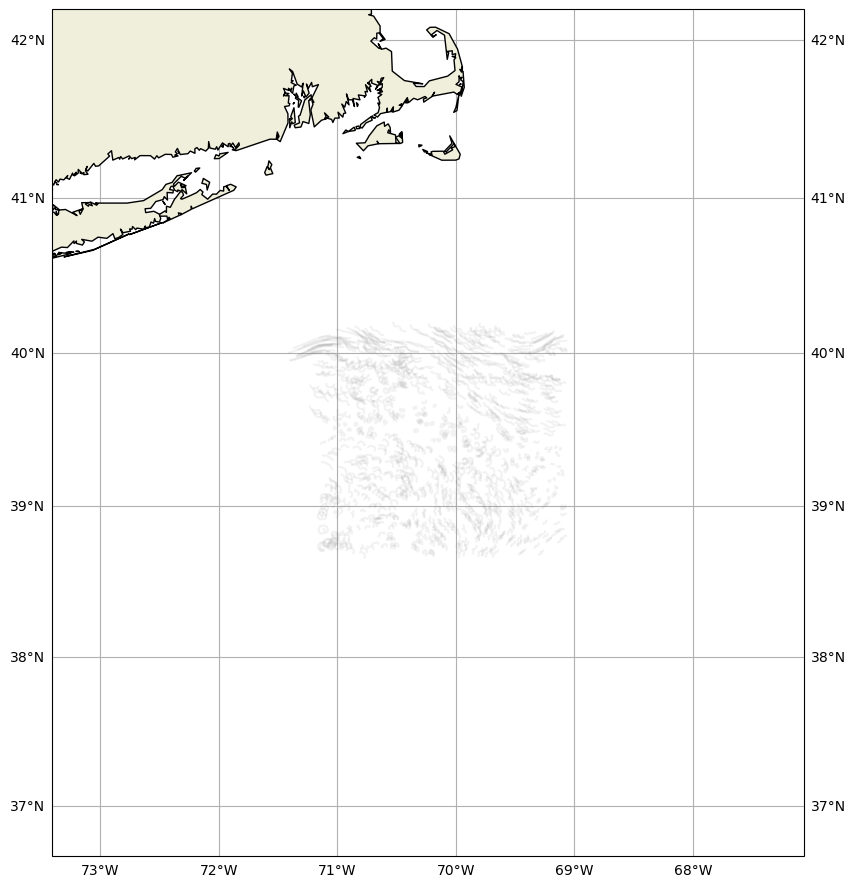

In [21]:
ds = xr.open_zarr("test.zarr")
ds.traj.plot(margin=2)
plt.show()

In [24]:
ds

<xarray.Dataset> Size: 488kB
Dimensions:     (trajectory: 1000, obs: 24)
Coordinates:
  * obs         (obs) int32 96B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
  * trajectory  (trajectory) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
Data variables:
    lat         (trajectory, obs) float32 96kB dask.array<chunksize=(1000, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 96kB dask.array<chunksize=(1000, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 192kB dask.array<chunksize=(1000, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 96kB dask.array<chunksize=(1000, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4
    parcels_mesh:           spherical
    parcels_version:        3.0.4

## time order bug in later files

In [108]:
not np.all (time[1:] - time[:-1]) > 0
not np.all (time[1:] - time[:-1]) > 0

False